## [E17] pix2pix 모델을 활용한 채색하기 프로젝트

-  __Encoder-Decoder Generator__ 를 사용한 pix2pix 모델과 __U-Net Generator__ 를 사용한 pix2pix모델을 구현해보자.

- [참고자료|pix2pix_케라스](https://www.tensorflow.org/tutorials/generative/pix2pix#%EB%8D%B0%EC%9D%B4%ED%84%B0%EC%84%B8%ED%8A%B8_%EB%A1%9C%EB%93%9C%ED%95%98%EA%B8%B0)

In [1]:
#!sudo apt-get install -y fonts-nanum
#!sudo fc-cache -fv
#!rm ~/.cache/matplotlib -rf

In [2]:
import time
from IPython import display
%matplotlib inline
# 한국어 폰트 설치를 확인합니다.  
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
plt.rc('font', family='NanumBarunGothic')

In [3]:
#cd drive/MyDrive/AIFFEL/E17/data

In [4]:
#!unzip cityscapes.zip

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [6]:
import os

data_path = '/content/drive/MyDrive/AIFFEL/E17/data/cityscapes/train/'
print("number of train examples :", len(os.listdir(data_path)))

number of train examples : 1000


In [41]:
def make_folder(try_): # 저장할 폴더 만드는 함수
    os.mkdir('/content/drive/MyDrive/AIFFEL/E17/cityscapes/try{}'.format(try_)) 
    os.mkdir('/content/drive/MyDrive/AIFFEL/E17/cityscapes/try{}/training_checkpoints'.format(try_)) 
    os.mkdir('/content/drive/MyDrive/AIFFEL/E17/cityscapes/try{}/generated_samples'.format(try_))
    os.mkdir('/content/drive/MyDrive/AIFFEL/E17/cityscapes/try{}/training_history'.format(try_))

### 학습 시킬 데이터 관찰하기

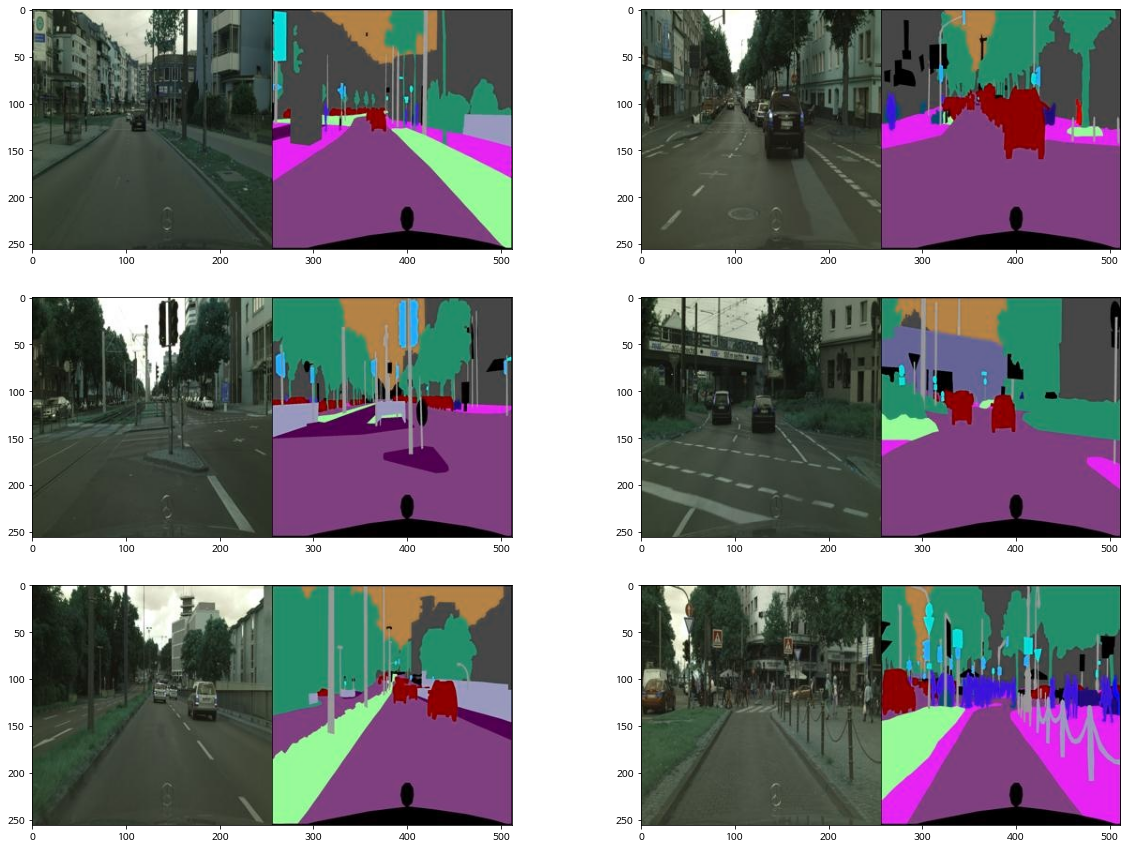

In [10]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(20,15))
for i in range(1, 7):
    f = data_path + os.listdir(data_path)[np.random.randint(800)]
    img = cv2.imread(f, cv2.IMREAD_COLOR)
    plt.subplot(3,2,i)
    plt.imshow(img)

In [11]:
f = data_path + os.listdir(data_path)[0]
img = cv2.imread(f, cv2.IMREAD_COLOR)
print("이미지 배열 크기(height, width,channel):",img.shape)

이미지 배열 크기(height, width,channel): (256, 512, 3)


- 이미 우리는 opencv로 이미지를 불러왔을때 numpy배열이 (세로, 가로, 채널)의 정보를 담고 있다는 것을 알고 있다. 채널은 제외하고 테스트해보자
    1. 첫번째 인덱스를 슬라이싱해서 시각화하기(세로로 반이 잘림)
    2. 두번째 인덱스를 슬라이싱해서 시각화하기(가로로 반이 잘림)

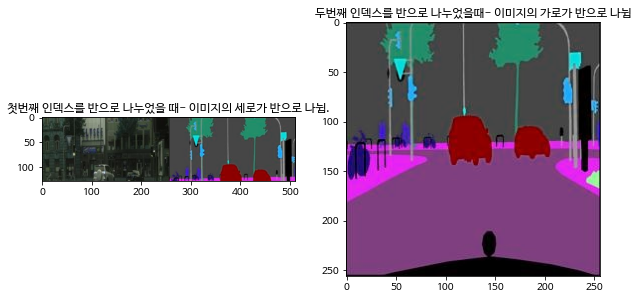

In [12]:
plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.imshow(img[:256//2,])
plt.title("첫번째 인덱스를 반으로 나누었을 때- 이미지의 세로가 반으로 나뉨.")
plt.subplot(1,2,2)
plt.imshow(img[:,512//2:,:])
plt.title("두번째 인덱스를 반으로 나누었을때- 이미지의 가로가 반으로 나뉨")
plt.show()

그러므로 왼쪽 이미지와 오른쪽 이미지를 나누어서 label과 설명변수로 슬라이싱한다.

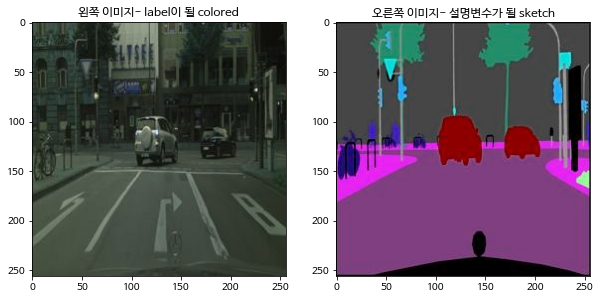

In [13]:
plt.figure(figsize=(10,10))

plt.subplot(1,2,1)
plt.imshow(img[:,:512//2,:])
plt.title("왼쪽 이미지- label이 될 colored")

plt.subplot(1,2,2)
plt.imshow(img[:,512//2:,])
plt.title("오른쪽 이미지- 설명변수가 될 sketch")
plt.show()

이미지에서 볼수 있듯이 왼쪽(width:0 ~ 256)이 label에 해당하는 colored이고, 오른쪽(width:256 ~ 512)이 설명변수에 해당하는 sketch이다. 아래의 load_img에서 이미지를 전처리하는 과정에서 주의해야한다. __(노드 작성자가 데이터 구조가 다르기 때문에 전처리에 유의해야한다고 한 부분인듯)__

#### load_img 함수를 sketch와 colored를 구분하는 슬라이싱 코드를 수정해준다.

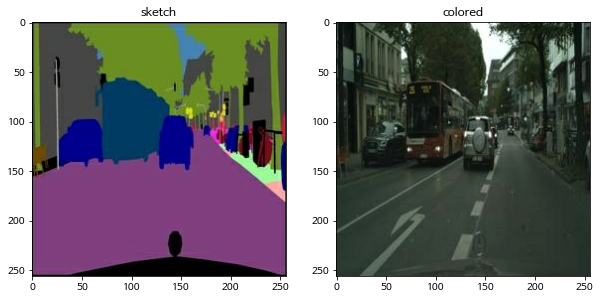

In [14]:
import tensorflow as tf

def normalize(x):
    x = tf.cast(x, tf.float32)
    return (x/127.5) - 1

def denormalize(x):
    x = (x+1)*127.5
    x = x.numpy()
    return x.astype(np.uint8)

def load_img(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_image(img, 3)
    
    # width 512를 반으로 나누면 sketch와 colored의 경계지점의 포인트이다
    w = tf.shape(img)[1] // 2   
    sketch = img[:, w:, :]     # 경계지점 포인트 w이후
    sketch = tf.cast(sketch, tf.float32)
    colored = img[:, :w, :]    # 경계지점 포인트 w 이전
    colored = tf.cast(colored, tf.float32)
    return normalize(sketch), normalize(colored)

f = data_path + os.listdir(data_path)[1]
sketch, colored = load_img(f)

plt.figure(figsize=(10,7))
plt.subplot(1,2,1); plt.imshow(denormalize(sketch)); plt.title("sketch")
plt.subplot(1,2,2); plt.imshow(denormalize(colored)); plt.title("colored")
plt.show()

- load_img부분을 수정한 결과 sketch 이미지와 colored 이미지가 잘 구분되었다.

### 이미지 데이터 Augmentation 

In [15]:
stacked = tf.concat([sketch, colored], axis=-1)
stacked.shape

TensorShape([256, 256, 6])

- 원본의 이미지는 채널의 방향으로 이미지 sketch, colored 이미지의 배열을 합친 것을 알수 있다.    
- 아래의 코드는 (좌/우/위/아래)방향으로 pad를 30pixel씩 넣으려고 한다. __padding처리하고 나면 배열의 모양은 width와 height이 모두 60씩 늘어난 (316,316,6)__ 이 된다. 나중에 crop을 하거나 rotation하기 위해서 이미지에 padding을 입히는 것으로 보인다. 
- 그리고 이 padding을 50%의 확률로 
    - pad에 기존 이미지를 reflect시키고 
    - pad에 1. 을 채워 넣는다(즉, 흰색으로 만든다.)

padding처리 한 후의 배열 모양: (316, 316, 6) (316, 316, 6)


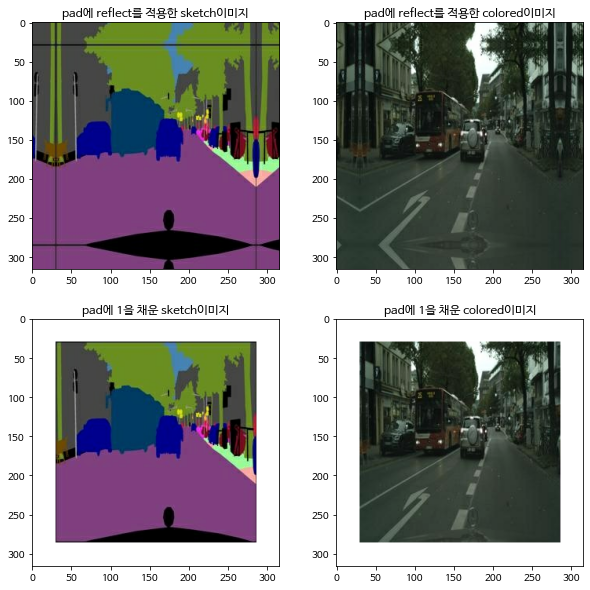

In [16]:
_pad = tf.constant([[30,30],[30,30],[0,0]])
prop=tf.random.uniform(())

padded1 = tf.pad(stacked, _pad, "REFLECT") # 
padded2 = tf.pad(stacked, _pad, "CONSTANT", constant_values=1.)
print("padding처리 한 후의 배열 모양:",padded1.shape, padded2.shape)
plt.figure(figsize=(10,10))
plt.subplot(2,2,1)
plt.title("pad에 reflect를 적용한 sketch이미지")
plt.imshow(denormalize(padded1[:,:,:3]))
plt.subplot(2,2,2)
plt.imshow(denormalize(padded1[:,:,3:]))
plt.title("pad에 reflect를 적용한 colored이미지")

plt.subplot(2,2,3)
plt.imshow(denormalize(padded2[:,:,:3]))
plt.title("pad에 1을 채운 sketch이미지")
plt.subplot(2,2,4)
plt.imshow(denormalize(padded2[:,:,3:]))
plt.title("pad에 1을 채운 colored이미지")
plt.show()

위의 padding을 적용한 이미지를 random하게 자르고 회전하고, 좌우, 위아래로 뒤집는다.

In [17]:
from tensorflow import image
from tensorflow.keras.preprocessing.image import random_rotation

@tf.function() # 빠른 텐서플로 연산을 위해 @tf.function()을 사용합니다. 
def apply_augmentation(sketch, colored):
    stacked = tf.concat([sketch, colored], axis=-1) # stacked 의 shape는 256,256,6
    
    _pad = tf.constant([[30,30],[30,30],[0,0]])
    if tf.random.uniform(()) < .5: # 0.5의 확률로
        padded = tf.pad(stacked, _pad, "REFLECT") # reflect한 padding을 입힌다.
    else:
        padded = tf.pad(stacked, _pad, "CONSTANT", constant_values=1.) # 1을 채운 패딩

    out = image.random_crop(padded, size=[256, 256, 6]) # 이미지를 랜덤하게 crop
    
    out = image.random_flip_left_right(out) # 랜덤하게 좌우 반전
    out = image.random_flip_up_down(out) # 랜덤하게 위 아래 반전
    
    if tf.random.uniform(()) < .5:
        degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32) # 랜덤한 각도로 하게
        out = image.rot90(out, k=degree) # 회전한다.
    
    return out[...,:3], out[...,3:]   


- apply_augmentation 함수를 적용할 원본이미지 확인

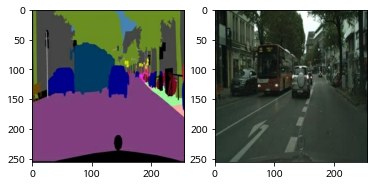

In [18]:
plt.subplot(1,2,1)
plt.imshow(denormalize(sketch))
plt.subplot(1,2,2)
plt.imshow(denormalize(colored))
plt.show()

- augmentation한 결과를 확인해보자.

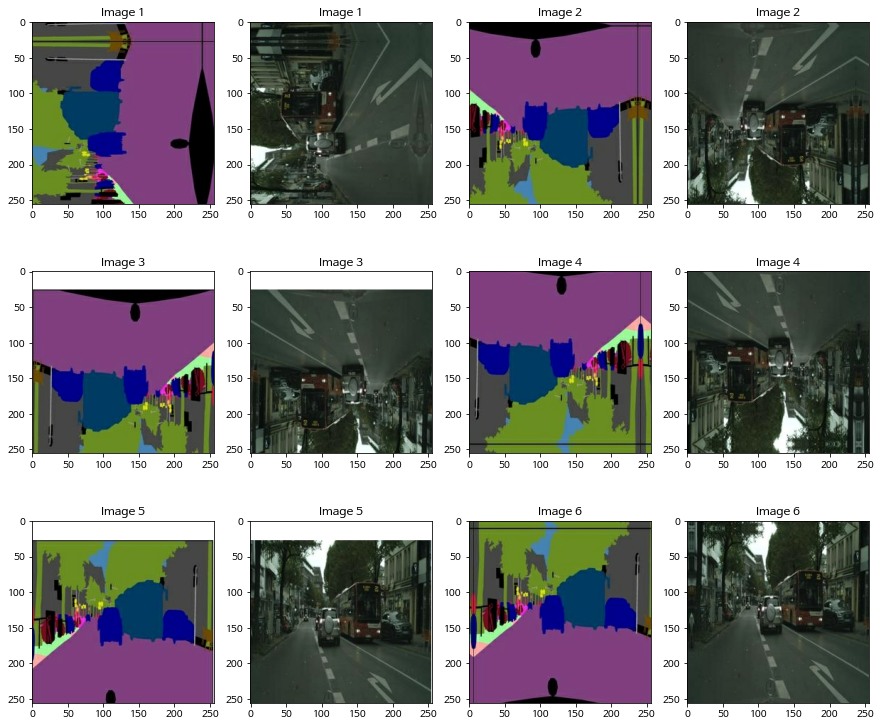

In [19]:
plt.figure(figsize=(15,13))
img_n = 1
lst=[]
for i in range(1, 13, 2):
    augmented_sketch, augmented_colored = apply_augmentation(sketch, colored)
    lst.append((augmented_sketch, augmented_colored))
    plt.subplot(3,4,i)
    plt.imshow(denormalize(augmented_sketch)); plt.title(f"Image {img_n}")
    plt.subplot(3,4,i+1); 
    plt.imshow(denormalize(augmented_colored)); plt.title(f"Image {img_n}")
    img_n += 1

- augmentation 된 이미지 한장 확인해보자.

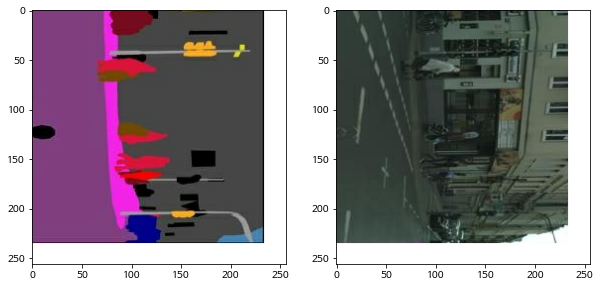

In [20]:
from tensorflow import data

def get_train(img_path):
    sketch, colored = load_img(img_path)
    sketch, colored = apply_augmentation(sketch, colored)
    return sketch, colored

train_images = data.Dataset.list_files(data_path + "*.jpg")
train_images = train_images.map(get_train).shuffle(100).batch(4)

sample = train_images.take(1)
sample = list(sample.as_numpy_iterator())
sketch, colored = (sample[0][0]+1)*127.5, (sample[0][1]+1)*127.5

plt.figure(figsize=(10,5))
plt.subplot(1,2,1); plt.imshow(sketch[0].astype(np.uint8))
plt.subplot(1,2,2); plt.imshow(colored[0].astype(np.uint8))

## pix2pix의 Generator 구현하기

- Generator를 앞서 말했듯이 __Encoder-Decoder Generator__ 와 __skip-connection을 사용한 U-Net Generator__ , 이렇게 두가지를 만들고 구현한다.

### Generator의 EncoderBlock과 DecoderBlock
- encoder-decoder Generator와 U-Net Generator은 동일한 EncodeBlock, DecodeBlock을 쓴다.


In [21]:
from tensorflow.keras import layers, Input, Model

class EncodeBlock(layers.Layer):
    def __init__(self, n_filters, use_bn=True):
        super(EncodeBlock, self).__init__()
        self.use_bn = use_bn       
        self.conv = layers.Conv2D(n_filters, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.lrelu= layers.LeakyReLU(0.2)

    def call(self, x):
        x = self.conv(x)
        if self.use_bn:
            x = self.batchnorm(x)
        return self.lrelu(x)

class DecodeBlock(layers.Layer):
    def __init__(self, f, dropout=True):
        super(DecodeBlock, self).__init__()
        self.dropout = dropout
        self.Transconv = layers.Conv2DTranspose(f, 4, 2, "same", use_bias=False)
        self.batchnorm = layers.BatchNormalization()
        self.relu = layers.ReLU()
        
    def call(self, x):
        x = self.Transconv(x)
        x = self.batchnorm(x)
        if self.dropout:
            x = layers.Dropout(.5)(x)
        return self.relu(x)


### Encoder와 Decoder

In [22]:
class Encoder(layers.Layer):
    def __init__(self):
        super(Encoder, self).__init__()
        filters = [64,128,256,512,512,512,512,512]  
        
        self.blocks = []
        for i, f in enumerate(filters):
            if i == 0:
                self.blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.blocks.append(EncodeBlock(f))
    
    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x
    
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

    
class Decoder(layers.Layer):
    def __init__(self):
        super(Decoder, self).__init__()
        filters = [512,512,512,512,256,128,64]
        
        self.blocks = []
        for i, f in enumerate(filters):
            if i < 3:
                self.blocks.append(DecodeBlock(f))
            else:
                self.blocks.append(DecodeBlock(f, dropout=False))
                
        self.blocks.append(layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False))
        
    def call(self, x):
        for block in self.blocks:
            x = block(x)
        return x
            
    def get_summary(self, input_shape=(1,1,512)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()




In [23]:
Encoder().get_summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 encode_block (EncodeBlock)  (None, 128, 128, 64)      3072      
                                                                 
 encode_block_1 (EncodeBlock  (None, 64, 64, 128)      131584    
 )                                                               
                                                                 
 encode_block_2 (EncodeBlock  (None, 32, 32, 256)      525312    
 )                                                               
                                                                 
 encode_block_3 (EncodeBlock  (None, 16, 16, 512)      2099200   
 )                                                               
                                                             

In [24]:
Decoder().get_summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1, 1, 512)]       0         
                                                                 
 decode_block (DecodeBlock)  (None, 2, 2, 512)         4196352   
                                                                 
 decode_block_1 (DecodeBlock  (None, 4, 4, 512)        4196352   
 )                                                               
                                                                 
 decode_block_2 (DecodeBlock  (None, 8, 8, 512)        4196352   
 )                                                               
                                                                 
 decode_block_3 (DecodeBlock  (None, 16, 16, 512)      4196352   
 )                                                               
                                                           

- encoder는 19,538,688개의 파라미터, decoder는 19,537,792개의 파라미터를 학습시킨다.

### Encoder-Decoder Generator 만들기

 - 앞에서 구현된 Encoder와 Decoder를 연결하여 Generator를 만든다.

In [25]:
class EncoderDecoderGenerator(Model):
    def __init__(self):
        super(EncoderDecoderGenerator, self).__init__()
        self.encoder = Encoder()
        self.decoder = Decoder()
    
    def call(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
   
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()

    def build_graph(self):
        x = Input(shape=(dim))
        return Model(inputs=[x], outputs=self.call(x))


### EncoderDecoderGenerator 시각화

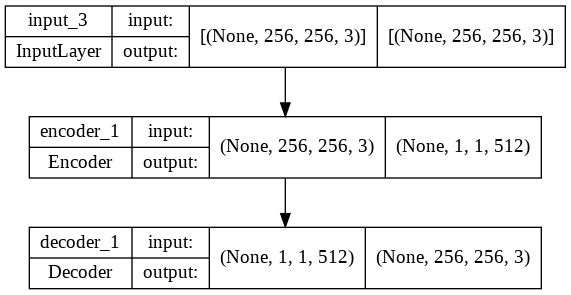

In [26]:
dim = (256,256,3)
model = EncoderDecoderGenerator()
model.build((None, *dim))

tf.keras.utils.plot_model(
    model.build_graph(),                      # here is the trick (for now)
    to_file='model.png', dpi=96,              # saving  
    show_shapes=True, show_layer_names=True,  # show shapes and layer name
    expand_nested=False                       # will show nested block
)

In [27]:
EncoderDecoderGenerator().get_summary() 

Model: "model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 encoder_2 (Encoder)         (None, 1, 1, 512)         19544576  
                                                                 
 decoder_2 (Decoder)         (None, 256, 256, 3)       19542784  
                                                                 
Total params: 39,087,360
Trainable params: 39,076,480
Non-trainable params: 10,880
_________________________________________________________________


- Encoder-Decoder Generator는 총 4000만개의 파라미터를 학습시켜야한다.

### U-Net 구조를 사용한 Generator
- skip connection을 추가한 U-NetGenerator

In [28]:
class UNetGenerator(Model): 
    def __init__(self):
        super(UNetGenerator, self).__init__()
        encode_filters = [64,128,256,512,512,512,512,512]
        decode_filters = [512,512,512,512,256,128,64]
        
        self.encode_blocks = []
        for i, f in enumerate(encode_filters):
            if i == 0:
                self.encode_blocks.append(EncodeBlock(f, use_bn=False))
            else:
                self.encode_blocks.append(EncodeBlock(f))
        
        self.decode_blocks = []
        for i, f in enumerate(decode_filters):
            if i < 3:
                self.decode_blocks.append(DecodeBlock(f))
            else:
                self.decode_blocks.append(DecodeBlock(f, dropout=False))
        
        self.last_conv = layers.Conv2DTranspose(3, 4, 2, "same", use_bias=False)
    
    def call(self, x):
        features = []
        for block in self.encode_blocks:
            x = block(x)
            features.append(x)    # features에는 encode_blocks가 sequence 모델로 차례대로 입력
        
        features = features[:-1]  # encode_blocks의 마지막은 decode_block의 첫번째 block과 
                                  # 직접 연결되기 때문에 마지막 encode_block는 포함시키지 않는다.
                    
        for block, feat in zip(self.decode_blocks, features[::-1]): 
            # 뒤에서 부터 하나씩 꺼내서 decode blocks과 concatenate한다. 
            x = block(x)
            x = layers.Concatenate()([x, feat])
        
        x = self.last_conv(x)
        return x
                
    def get_summary(self, input_shape=(256,256,3)):
        inputs = Input(input_shape)
        return Model(inputs, self.call(inputs)).summary()
    
    def build_graph(self):
        x = Input(shape=(dim))
        return Model(inputs=[x], outputs=self.call(x))

### UNetGenerator 시각화

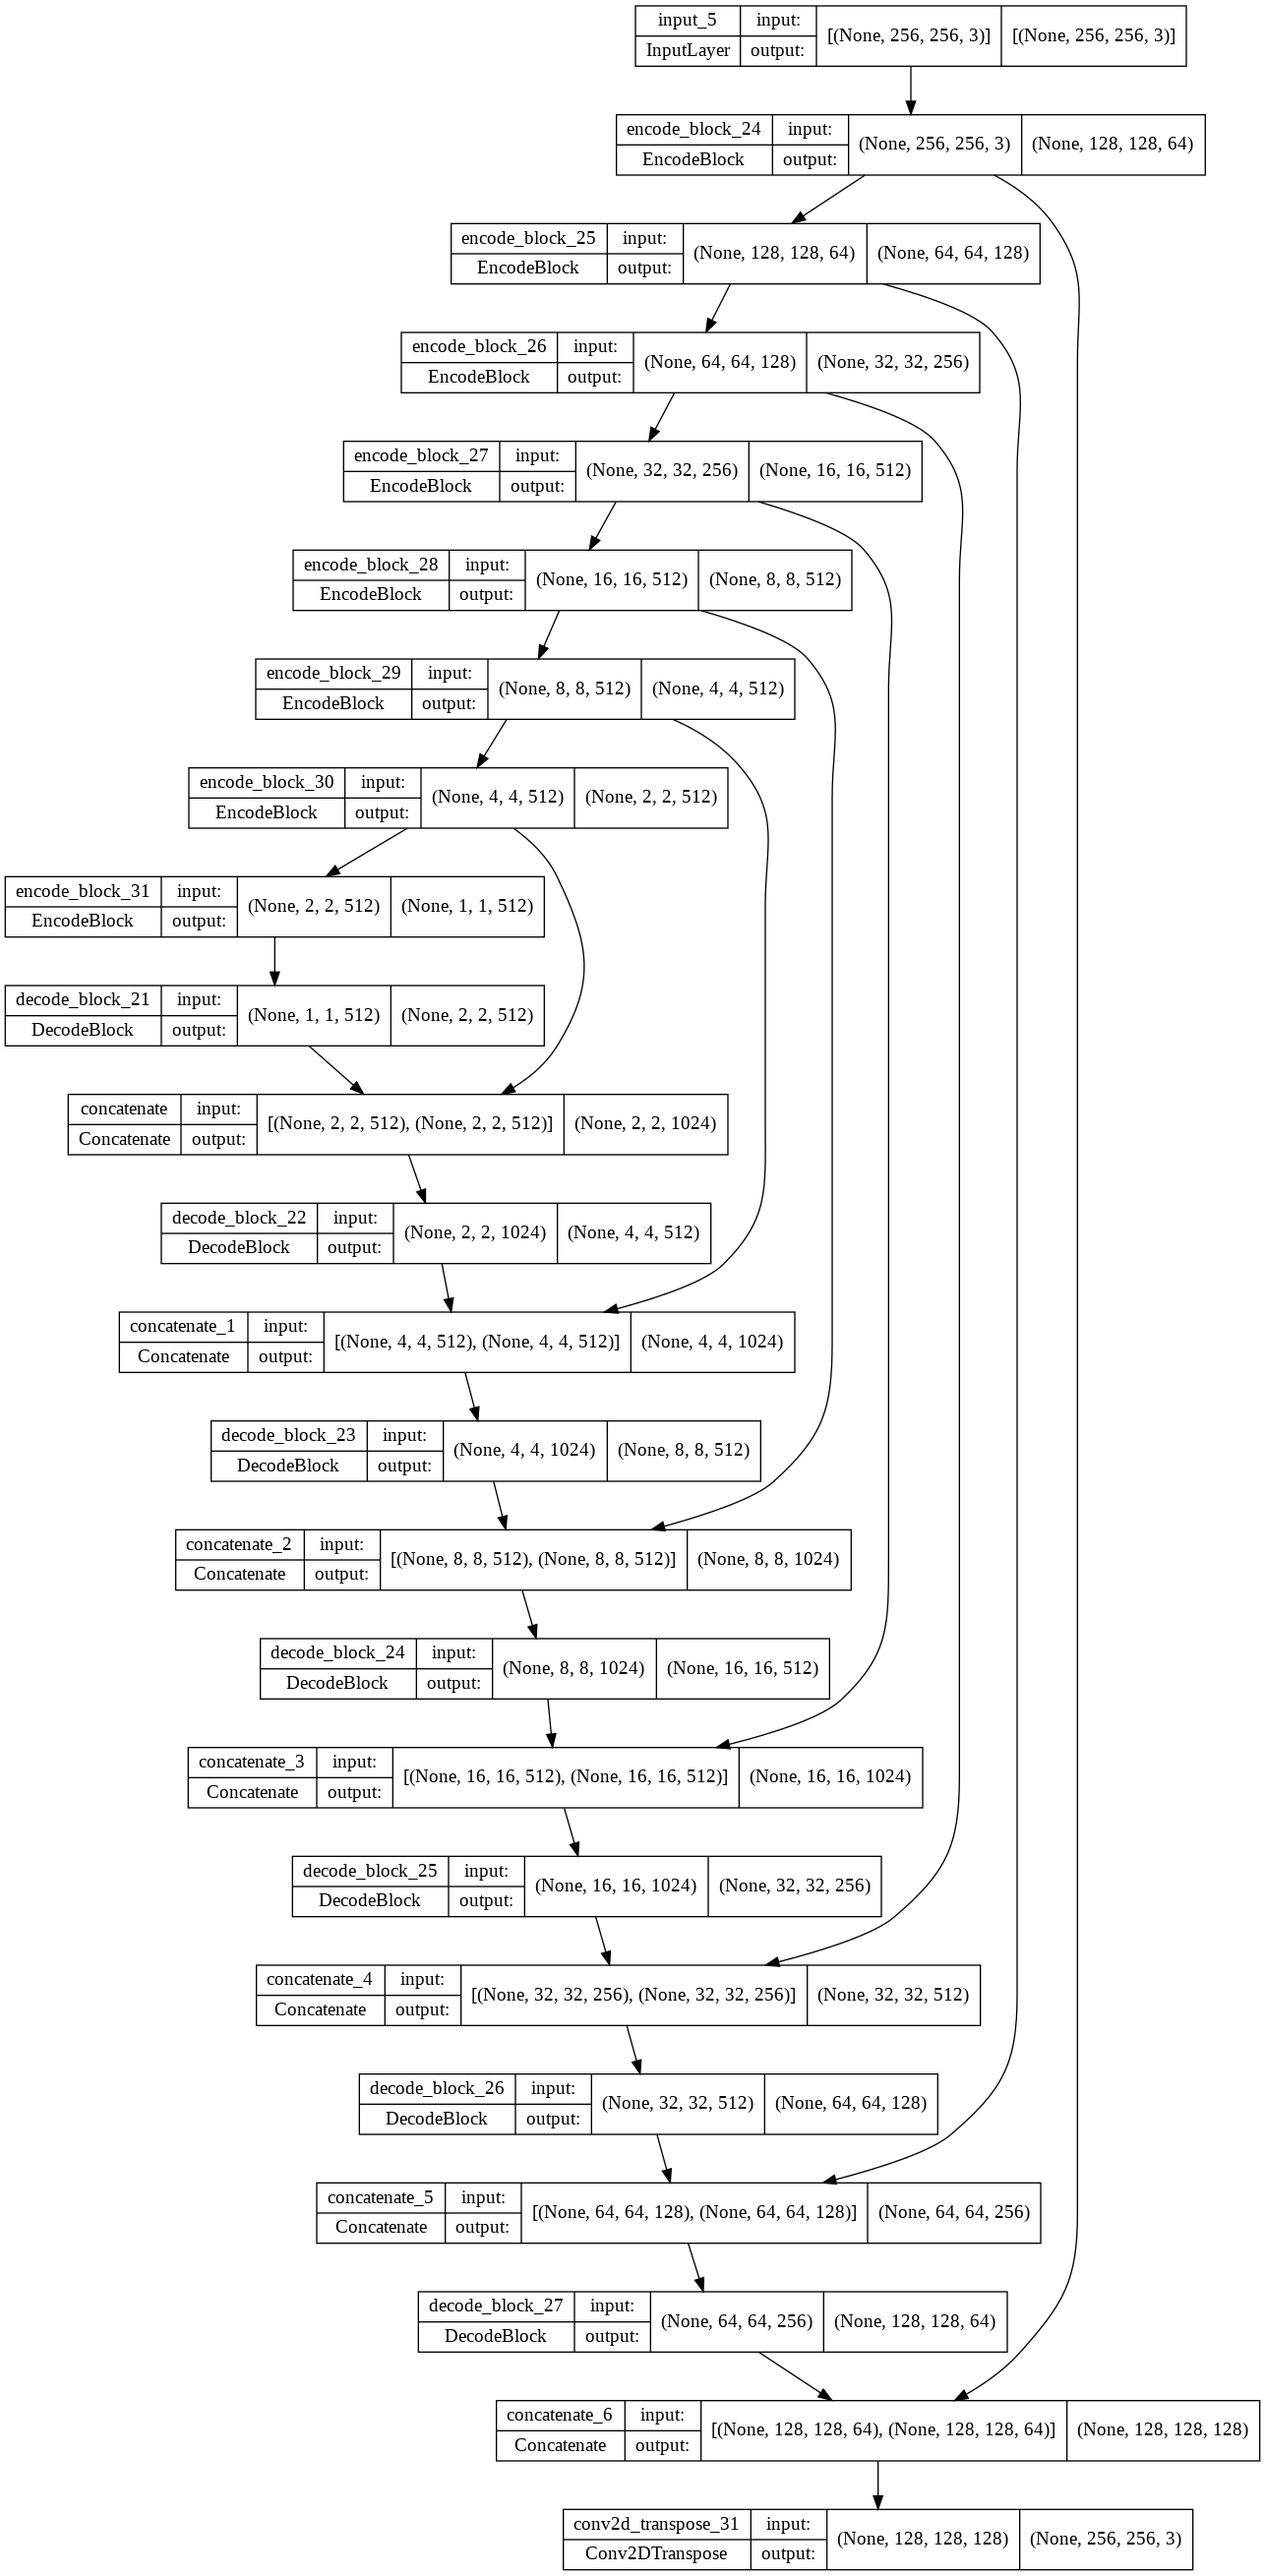

In [29]:
from tensorflow.keras.utils import plot_model
dim = (256,256,3)
model = UNetGenerator()
model.build((None, *dim))

tf.keras.utils.plot_model(
    model.build_graph(),                      # here is the trick (for now)
    to_file='model.png', dpi=96,              # saving  
    show_shapes=True, show_layer_names=True,  # show shapes and layer name
    expand_nested=False                       # will show nested block
)

In [30]:
UNetGenerator().get_summary()

Model: "model_5"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 encode_block_32 (EncodeBlock)  (None, 128, 128, 64  3072        ['input_6[0][0]']                
                                )                                                                 
                                                                                                  
 encode_block_33 (EncodeBlock)  (None, 64, 64, 128)  131584      ['encode_block_32[0][0]']        
                                                                                            

- skip connection을 추가한 UNetGenerator는 파라미터가 54,425,856개로 Encoder-Decoder Generator구조에 비해서 1500만개 정도 늘어났다.

- U-NetGenerator는 skip connection으로 인해 decoder의 각 블록에서 입력받는 채널 수가 늘어가서 블록 내에서 학습하는 convolution 레이어에서 학습되어지는 필터의 크기가 커졌기 때문에 파라미터의 수가 늘어났다.

### Discriminator 구현하기


In [31]:
class DiscBlock(layers.Layer):
    def __init__(self, n_filters, stride=2, custom_pad=False, use_bn=True, act=True):
        super(DiscBlock, self).__init__()
        self.custom_pad = custom_pad
        self.use_bn = use_bn
        self.act = act
        
        if custom_pad:
            self.padding = layers.ZeroPadding2D()
            self.conv = layers.Conv2D(n_filters, 4, stride, "valid", use_bias=False)
        else:
            self.conv = layers.Conv2D(n_filters, 4, stride, "same", use_bias=False)
        
        self.batchnorm = layers.BatchNormalization() if use_bn else None
        self.lrelu = layers.LeakyReLU(0.2) if act else None
        
    def call(self, x):
        if self.custom_pad:
            x = self.padding(x)
            x = self.conv(x)
        else:
            x = self.conv(x)
                
        if self.use_bn:
            x = self.batchnorm(x)
            
        if self.act:
            x = self.lrelu(x)
        return x 


In [32]:
inputs = Input((128,128,32))
out = layers.ZeroPadding2D()(inputs)
out = layers.Conv2D(64, 4, 1, "valid", use_bias=False)(out)
out = layers.BatchNormalization()(out)
out = layers.LeakyReLU(0.2)(out)

Model(inputs, out).summary()

Model: "model_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_7 (InputLayer)        [(None, 128, 128, 32)]    0         
                                                                 
 zero_padding2d (ZeroPadding  (None, 130, 130, 32)     0         
 2D)                                                             
                                                                 
 conv2d_40 (Conv2D)          (None, 127, 127, 64)      32768     
                                                                 
 batch_normalization_75 (Bat  (None, 127, 127, 64)     256       
 chNormalization)                                                
                                                                 
 leaky_re_lu_40 (LeakyReLU)  (None, 127, 127, 64)      0         
                                                                 
Total params: 33,024
Trainable params: 32,896
Non-trainable

In [33]:
class Discriminator(Model):
    def __init__(self):
        super(Discriminator, self).__init__()
        
        self.block1 = layers.Concatenate()
        self.block2 = DiscBlock(n_filters=64, stride=2, custom_pad=False, use_bn=False, act=True)
        self.block3 = DiscBlock(n_filters=128, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block4 = DiscBlock(n_filters=256, stride=2, custom_pad=False, use_bn=True, act=True)
        self.block5 = DiscBlock(n_filters=512, stride=1, custom_pad=True, use_bn=True, act=True)
        self.block6 = DiscBlock(n_filters=1, stride=1, custom_pad=True, use_bn=False, act=False)
        self.sigmoid = layers.Activation("sigmoid")
        
        # filters = [64,128,256,512,1]
        # self.blocks = [layers.Concatenate()]
        # for i, f in enumerate(filters):
        #     self.blocks.append(DiscBlock(
        #         n_filters=f,
        #         strides=2 if i<3 else 1,
        #         custom_pad=False if i<3 else True,
        #         use_bn=False if i==0 and i==4 else True,
        #         act=True if i<4 else False
        #     ))
    
    def call(self, x, y):
        out = self.block1([x, y]) # x: input 이미지 , y: target 이미지
        out = self.block2(out)
        out = self.block3(out)
        out = self.block4(out)
        out = self.block5(out)
        out = self.block6(out)
        return self.sigmoid(out)
    
    def get_summary(self, x_shape=(256,256,3), y_shape=(256,256,3)):
        x, y = Input(x_shape), Input(y_shape) 
        return Model((x, y), self.call(x, y)).summary()
    

In [34]:
Discriminator().get_summary()

Model: "model_7"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_8 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 input_9 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 concatenate_14 (Concatenate)   (None, 256, 256, 6)  0           ['input_8[0][0]',                
                                                                  'input_9[0][0]']          

임의의 숫자로 채워진 (256,256,3) 크기의 배열을 입력으로 넣어서 나오는 (30,30) 출력을 시각화해보자

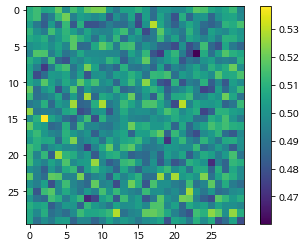

In [35]:
x = tf.random.normal([1,256,256,3])
y = tf.random.uniform([1,256,256,3])

disc_out = Discriminator()(x, y)
plt.imshow(disc_out[0, ... ,0])
plt.colorbar()

In [36]:
from tensorflow.keras import losses

bce = losses.BinaryCrossentropy(from_logits=False)
mae = losses.MeanAbsoluteError()

def get_gene_loss(fake_output, real_output, fake_disc):
    l1_loss = mae(real_output, fake_output)
    gene_loss = bce(tf.ones_like(fake_disc), fake_disc)
    return gene_loss, l1_loss

def get_disc_loss(fake_disc, real_disc):
    return bce(tf.zeros_like(fake_disc), fake_disc) + bce(tf.ones_like(real_disc), real_disc)



In [37]:
from tensorflow.keras import optimizers

gene_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)
disc_opt = optimizers.Adam(2e-4, beta_1=.5, beta_2=.999)


### 학습(하나의 step학습)

In [38]:
@tf.function
def train_step(sketch, real_colored, L1_lambda): # 입력데이터/ sketch: input 이미지, real_colored: target 이미지 
    with tf.GradientTape() as gene_tape, tf.GradientTape() as disc_tape: # tf.GradientTape() 오픈/ 자동미분
        # Generator 예측/ 색칠한 이미지 생성
        fake_colored = generator(sketch, training=True)
        # Discriminator 예측/ 진짜인지 가짜인지 판별
        fake_disc = discriminator(sketch, fake_colored, training=True)
        real_disc = discriminator(sketch, real_colored, training=True)
        # Generator 손실 계산
        gene_loss, l1_loss = get_gene_loss(fake_colored, real_colored, fake_disc)
        gene_total_loss = gene_loss + (L1_lambda * l1_loss) ## <===== L1 손실 반영 λ=100
        # Discrminator 손실 계산
        disc_loss = get_disc_loss(fake_disc, real_disc)
                
    gene_gradient = gene_tape.gradient(gene_total_loss, generator.trainable_variables) # generator gradient 계산
    disc_gradient = disc_tape.gradient(disc_loss, discriminator.trainable_variables)# discriminator gradient 계산
    
    gene_opt.apply_gradients(zip(gene_gradient, generator.trainable_variables)) # optimizer에 generator gradient 입력
    disc_opt.apply_gradients(zip(disc_gradient, discriminator.trainable_variables)) # optimizer에 discriminator gradient 입력
    return gene_loss, l1_loss, disc_loss


In [39]:
generator = UNetGenerator()
discriminator = Discriminator()

In [42]:
make_folder(1)# 폴더 만들어주는 함수

### 0-1. 기본모델 :학습

EPOCH[200] - STEP[250] /Generator_loss:2.6557 /L1_loss:0.1756 /Discriminator_loss:0.4918



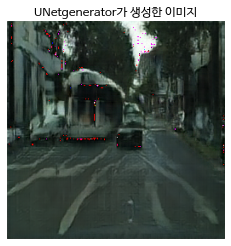

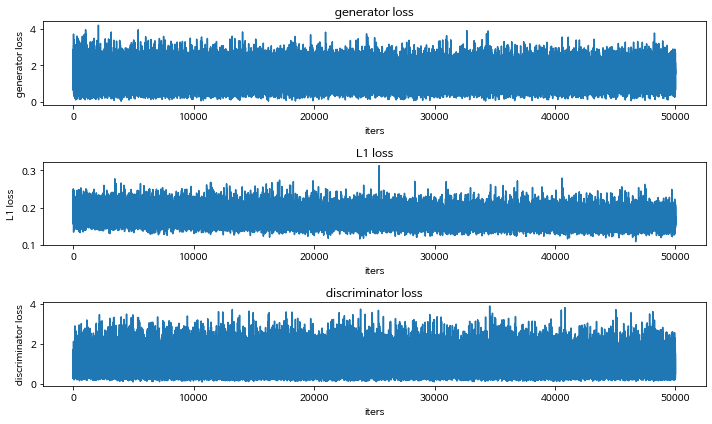

Time for training : 38 sec


In [50]:
try_=1
EPOCHS = 200
model1_loss={"gener_loss":[],"L1_loss":[],"discr_loss":[]}
save_every=1

for epoch in range(1, EPOCHS+1):  # epoch
    start=time.time()
    for i, (sketch, colored) in enumerate(train_images):  # batch step
        g_loss, l1_loss, d_loss = train_step(sketch, colored,L1_lambda=100) # L1 손실의 lambda 를 튜닝
        model1_loss["gener_loss"].append(g_loss)
        model1_loss["L1_loss"].append(l1_loss)
        model1_loss["discr_loss"].append(d_loss)
        
        
        # 50회 반복마다 손실을 출력합니다.
        if (i+1) % 50 == 0:
            display.clear_output(wait=True) # 셀의 화면 output을 지운다
            print(f"EPOCH[{epoch}] - STEP[{i+1}] /Generator_loss:{g_loss.numpy():.4f} /L1_loss:{l1_loss.numpy():.4f} /Discriminator_loss:{d_loss.numpy():.4f}", end="\n\n")
        
            test_ind = 1
            f = data_path + os.listdir(data_path)[test_ind]
            sketch, colored = load_img(f)
            pred = denormalize(generator(tf.expand_dims(sketch, 0)))
            # 생성된 이미지 시각화
            plt.imshow(pred[0])
            plt.title("UNetgenerator가 생성한 이미지")
            plt.axis("off")

            plt.savefig('/content/drive/MyDrive/AIFFEL/E17/cityscapes/try{}/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                       .format( try_,epoch,i))
            plt.show()
            # loss 시각화
            plt.figure(figsize=(10,6))
            plt.subplot(311)
            plt.title("generator loss")
            plt.plot(range(len(model1_loss["gener_loss"])), model1_loss["gener_loss"])
            plt.xlabel("iters")
            plt.ylabel("generator loss")

            plt.subplot(312)
            plt.title("L1 loss")
            plt.plot(range(len(model1_loss["L1_loss"])), model1_loss["L1_loss"])
            plt.xlabel("iters")
            plt.ylabel("L1 loss")

            plt.subplot(313)
            plt.title("discriminator loss")
            plt.plot(range(len(model1_loss["discr_loss"])), model1_loss["discr_loss"])
            plt.xlabel("iters")
            plt.ylabel("discriminator loss")            
            plt.savefig('/content/drive/MyDrive/AIFFEL/E17/cityscapes/try{}/training_history/train_history_{}_{:04d}.png'
                        .format(try_,epoch,i))
            plt.tight_layout()
            plt.show()
            
    if epoch % save_every == 0 :
        checkpoint_dir ='/content/drive/MyDrive/AIFFEL/E17/cityscapes/try{}/training_checkpoints'.format(try_)
        checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
        # checkpoint 저장
        checkpoint = tf.train.Checkpoint(generator_optimizer=gene_opt,
                                         discriminator_optimizer=disc_opt,
                                         generator=generator,
                                         discriminator=discriminator)
        
        checkpoint.save(file_prefix=checkpoint_prefix)
    
    print('Time for training : {} sec'.format(int(time.time()-start)))
    


In [67]:
checkpoint_dir = '/content/drive/MyDrive/AIFFEL/E17/cityscapes/try{}/training_checkpoints'.format(try_)
latest = tf.train.latest_checkpoint(checkpoint_dir)
checkpoint.restore(latest)

generator_ = checkpoint.generator
discriminator_ = checkpoint.discriminator

test_path= "/content/drive/MyDrive/AIFFEL/E17/data/cityscapes/val/"
f = [test_path + i for i in os.listdir(test_path)]

### 0-2. 기본 모델: 결과

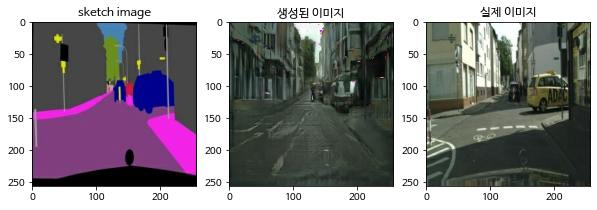

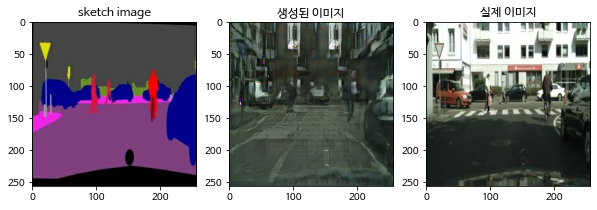

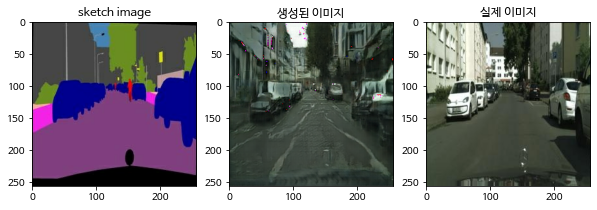

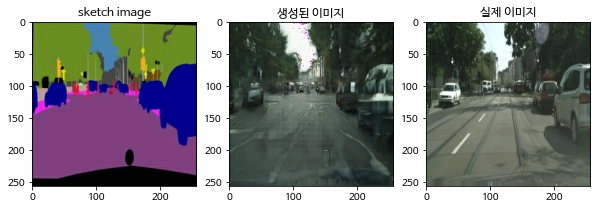

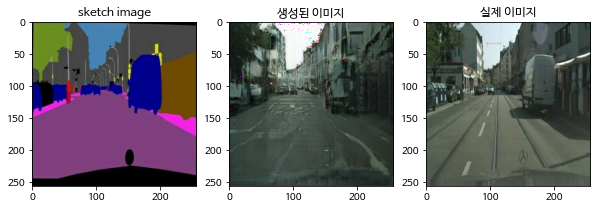

In [76]:
i=0
for file in f:
  sketch, colored = load_img(file)
  pred = generator_(tf.expand_dims(sketch, 0))
  pred = denormalize(pred)

  plt.figure(figsize=(10,20))
  plt.subplot(5,3,1+i); plt.imshow(denormalize(sketch));plt.title("sketch image")
  plt.subplot(5,3,2+i); plt.imshow(pred[0]);plt.title("생성된 이미지")
  plt.subplot(5,3,3+i); plt.imshow(denormalize(colored)); plt.title("실제 이미지")
  i+=3
plt.show()

대충 도로와 건물이 구분이 가고 자동차 같은게 나오긴 했지만 이미지가 매우 심하게 이그러져있다. 또한 하늘에 빨간색 점같은 것이 보이는 것을 확인할 수 있다.  epoch 200 추가로 학습 시켜보았다.

In [51]:
make_folder(1_1)# 폴더 만들어주는 함수

### 1-1. epoch 200 학습시킨 기본모델에 epoch 200추가 :학습

EPOCH[200] - STEP[250] /Generator_loss:2.8176 /L1_loss:0.1530 /Discriminator_loss:0.2468



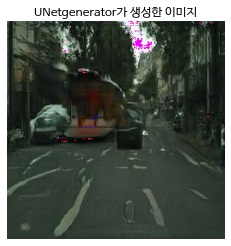

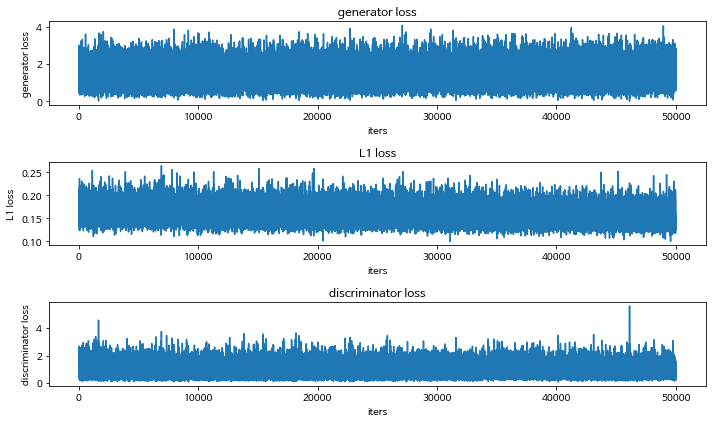

Time for training : 43 sec


In [54]:
try_=1_1
EPOCHS = 200
model1_loss={"gener_loss":[],"L1_loss":[],"discr_loss":[]}
save_every=1

for epoch in range(1, EPOCHS+1):  # epoch
    start=time.time()
    for i, (sketch, colored) in enumerate(train_images):  # batch step
        g_loss, l1_loss, d_loss = train_step(sketch, colored,L1_lambda=100) # L1 손실의 lambda 를 튜닝
        model1_loss["gener_loss"].append(g_loss)
        model1_loss["L1_loss"].append(l1_loss)
        model1_loss["discr_loss"].append(d_loss)
        
        
        # 50회 반복마다 손실을 출력합니다.
        if (i+1) % 50 == 0:
            display.clear_output(wait=True) # 셀의 화면 output을 지운다
            print(f"EPOCH[{epoch}] - STEP[{i+1}] /Generator_loss:{g_loss.numpy():.4f} /L1_loss:{l1_loss.numpy():.4f} /Discriminator_loss:{d_loss.numpy():.4f}", end="\n\n")
        
            test_ind = 1
            f = data_path + os.listdir(data_path)[test_ind]
            sketch, colored = load_img(f)
            pred = denormalize(generator(tf.expand_dims(sketch, 0)))
            # 생성된 이미지 시각화
            plt.imshow(pred[0])
            plt.title("UNetgenerator가 생성한 이미지")
            plt.axis("off")

            plt.savefig('/content/drive/MyDrive/AIFFEL/E17/cityscapes/try{}/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                       .format( try_,epoch,i))
            plt.show()
            # loss 시각화
            plt.figure(figsize=(10,6))
            plt.subplot(311)
            plt.title("generator loss")
            plt.plot(range(len(model1_loss["gener_loss"])), model1_loss["gener_loss"])
            plt.xlabel("iters")
            plt.ylabel("generator loss")

            plt.subplot(312)
            plt.title("L1 loss")
            plt.plot(range(len(model1_loss["L1_loss"])), model1_loss["L1_loss"])
            plt.xlabel("iters")
            plt.ylabel("L1 loss")

            plt.subplot(313)
            plt.title("discriminator loss")
            plt.plot(range(len(model1_loss["discr_loss"])), model1_loss["discr_loss"])
            plt.xlabel("iters")
            plt.ylabel("discriminator loss")            
            plt.savefig('/content/drive/MyDrive/AIFFEL/E17/cityscapes/try{}/training_history/train_history_{}_{:04d}.png'
                        .format(try_,epoch,i))
            plt.tight_layout()
            plt.show()
            
    if epoch % save_every == 0 :
        checkpoint_dir ='/content/drive/MyDrive/AIFFEL/E17/cityscapes/try{}/training_checkpoints'.format(try_)
        checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
        # checkpoint 저장
        checkpoint = tf.train.Checkpoint(generator_optimizer=gene_opt,
                                         discriminator_optimizer=disc_opt,
                                         generator=generator,
                                         discriminator=discriminator)
        
        checkpoint.save(file_prefix=checkpoint_prefix)
    
    print('Time for training : {} sec'.format(int(time.time()-start)))
    

### 1-2. epoch 200 학습시킨 기본모델에 epoch 200추가 : 결과

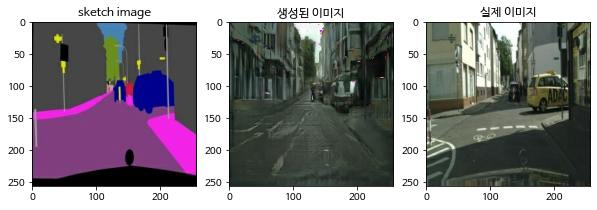

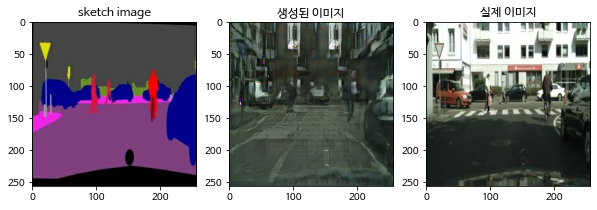

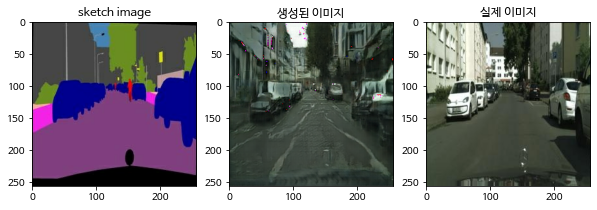

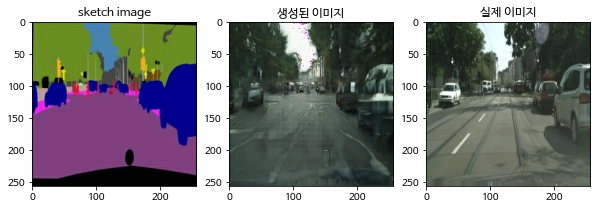

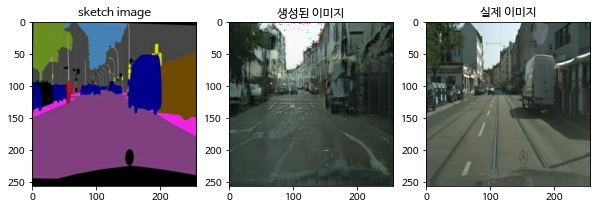

In [75]:
i=0
for file in f:
  sketch, colored = load_img(file)

  pred = generator(tf.expand_dims(sketch, 0))
  pred = denormalize(pred)

  plt.figure(figsize=(10,20))
  plt.subplot(5,3,1+i); plt.imshow(denormalize(sketch));plt.title("sketch image")
  plt.subplot(5,3,2+i); plt.imshow(pred[0]);plt.title("생성된 이미지")
  plt.subplot(5,3,3+i); plt.imshow(denormalize(colored)); plt.title("실제 이미지")
  i+=3
plt.show()

epoch 200으로 학습시킨 이미지에 epoch 200 추가로 학습을 시키니까, 기본모델을 epoch 200 학습 시켜서 생성시킨 이미지에 비해서 빨간 반점 의 개수도 줄어들었고 이미지의 형태도 많이 뚜렷해지는 것을 알수 있다. 

### 2-0. 데이터 augmentation 추가하기 : apply augmentation 코드 수정
- 현재 생성된 이미지는 실제 이미지에 비해서 많이 어둡게 생성된다. 아마도 __데이터의 밝은 부분들에 대해서는 학습이 잘 이루어지지 않은 것 같다는 생각이 들었다.__ 
- 생각해보면 기존의 코드는 주로 crop을 하거나 flip을 하는 사진의 사이즈나 모양을 주로 바꾸었다. 
- 이런 이유로 이미지의 색이나 밝기를 augmentation을 하고 싶었다. 
- 다만 우리가 __input 이미지로 쓰는 스케치 이미지는 객체마다 색깔이 정해져있다.__  __자동차는 남색, 사람은 빨간색, 인도는 마젠타__ 등등.  __input 이미지는 색을 바꾸면 테스트 데이터에는 없는 input 이미지의 색이 들어가게 되므로__ 색상을 aumentation 시킬때는 __output 이미지인 colored에만 augmentation을 해야한다고 생각이 든다.__
- 이미지의 색상을 바꾸더라도 범위를 정해줘야한다.
- 이미지를 normalization하니까 -1~1사이의 값으로 변환이 되었다. 즉, 이미지의 밝기를 정하더라도 이 범위 안에서 이미지의 밝기 등을 변경을 시켜야한다.

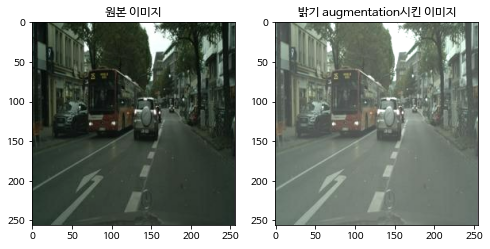

In [78]:
f = data_path + os.listdir(data_path)[1]
_, colored = load_img(f)
delta=tf.random.uniform([], minval=0.1, maxval=0.7) # delta 밝기 정도를 랜덤하게 뽑는다.
img=image.adjust_brightness(colored,delta=delta) # 밝기를 적용한다.
img=tf.where(tf.greater(img,1.0), 1.0, img) # 1보다 큰 값은 1로 바꿔준다.

plt.figure(figsize=(8,4))
plt.subplot(1,2,1)
plt.imshow(denormalize(colored))
plt.title("원본 이미지")
plt.subplot(1,2,2)
plt.imshow(denormalize(img))
plt.title("밝기 augmentation시킨 이미지")
plt.show()

In [79]:
print(img.numpy().max(),img.numpy().min())

1.0 -0.4747845


In [80]:
@tf.function() # 빠른 텐서플로 연산을 위해 @tf.function()을 사용합니다. 
def apply_augmentation(sketch, colored):
        
    if tf.random.uniform(())<.5: # 0.5의 확률로 밝기를 조절할지 정한다.
        delta=tf.random.uniform([], minval=0.1, maxval=0.7) # delta 밝기 정도를 랜덤하게 뽑는다.
        colored=image.adjust_brightness(colored,delta=delta) # 밝기를 적용한다.
        colored=tf.where(tf.greater(colored,1.0), 1.0, colored) # 1보다 큰 값은 1로 바꿔준다.
    else:
        cont=tf.random.uniform([], minval=0.1, maxval=0.7) # contrast를 어떻게 할지 정한다.
        colored=image.adjust_contrast(colored,cont) # contrast 적용
        colored=tf.where(tf.greater(colored,1.0), 1.0, colored) # 1보다 큰 값은 1로 바꿔준다.
        
    if tf.random.uniform(())<.5: # 0.5의 확률로 밝기를 조절할지 정한다.
        sat=tf.random.uniform([], minval=0.1, maxval=0.7) # saturation factor.
        colored=image.adjust_saturation(colored,sat) # saturation를 적용한다.
        colored=tf.where(tf.greater(colored,1.0), 1.0, colored) # 1보다 큰 값은 1로 바꿔준다.


    stacked = tf.concat([sketch, colored], axis=-1) # stacked 의 shape는 256,256,6
    
    _pad = tf.constant([[30,30],[30,30],[0,0]])
    if tf.random.uniform(()) < .5: # 0.5의 확률로
        padded = tf.pad(stacked, _pad, "REFLECT") # reflect한 padding을 입힌다.
    else:
        padded = tf.pad(stacked, _pad, "CONSTANT", constant_values=1.) # 1을 채운 패딩

    out = image.random_crop(padded, size=[256, 256, 6]) # 이미지를 랜덤하게 crop
    
    out = image.random_flip_left_right(out) # 랜덤하게 좌우 반전
    out = image.random_flip_up_down(out) # 랜덤하게 위 아래 반전
    
    if tf.random.uniform(()) < .5:
        degree = tf.random.uniform([], minval=1, maxval=4, dtype=tf.int32) # 랜덤한 각도로 하게
        out = image.rot90(out, k=degree) # 회전한다.

    return out[...,:3], out[...,3:]   


이미지의 값이 1.0보다 큰 값이 없는 것을 확인 할수 있다.
그렇다면 위에서 테스트한 사항을 적용해보자

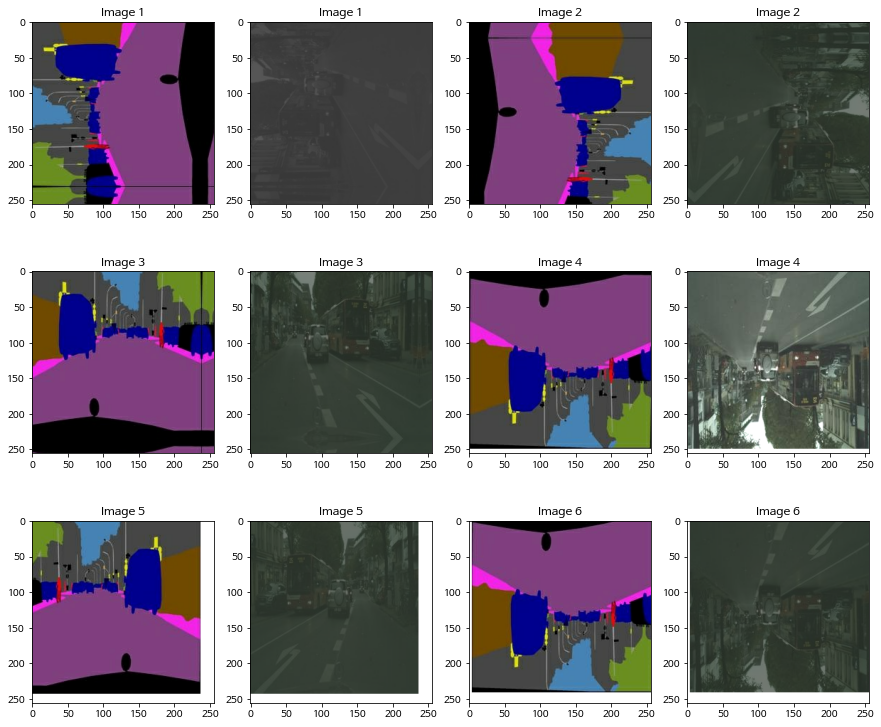

In [83]:
plt.figure(figsize=(15,13))
img_n = 1
lst=[]
for i in range(1, 13, 2):
    augmented_sketch, augmented_colored = apply_augmentation(sketch, colored)
    lst.append((augmented_sketch, augmented_colored))
    plt.subplot(3,4,i)
    plt.imshow(denormalize(augmented_sketch)); plt.title(f"Image {img_n}")
    plt.subplot(3,4,i+1); 
    plt.imshow(denormalize(augmented_colored)); plt.title(f"Image {img_n}")
    img_n += 1

apply_augmenation을 수정한 결과 기존의 rotation과 flip, crop과 함께 밝기와 contrast, satuation등이 다양하게 이뤄진 것을 확인 할수 있다. 

### 2-1. 데이터 augmentation 추가하기 : 학습

In [84]:
make_folder(2)# 폴더 만들어주는 함수

EPOCH[200] - STEP[250] /Generator_loss:1.1843 /L1_loss:0.1378 /Discriminator_loss:0.6360



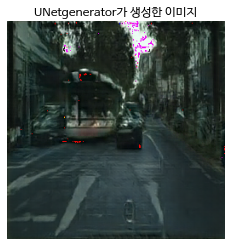

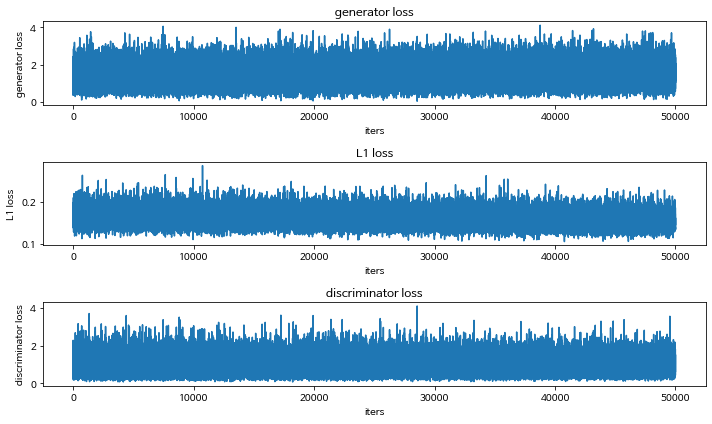

Time for training : 44 sec


In [85]:
try_=2
EPOCHS = 200
model1_loss={"gener_loss":[],"L1_loss":[],"discr_loss":[]}
save_every=1

for epoch in range(1, EPOCHS+1):  # epoch
    start=time.time()
    for i, (sketch, colored) in enumerate(train_images):  # batch step
        g_loss, l1_loss, d_loss = train_step(sketch, colored,L1_lambda=100) # L1 손실의 lambda 를 튜닝
        model1_loss["gener_loss"].append(g_loss)
        model1_loss["L1_loss"].append(l1_loss)
        model1_loss["discr_loss"].append(d_loss)
        
        
        # 50회 반복마다 손실을 출력합니다.
        if (i+1) % 50 == 0:
            display.clear_output(wait=True) # 셀의 화면 output을 지운다
            print(f"EPOCH[{epoch}] - STEP[{i+1}] /Generator_loss:{g_loss.numpy():.4f} /L1_loss:{l1_loss.numpy():.4f} /Discriminator_loss:{d_loss.numpy():.4f}", end="\n\n")
        
            test_ind = 1
            f = data_path + os.listdir(data_path)[test_ind]
            sketch, colored = load_img(f)
            pred = denormalize(generator(tf.expand_dims(sketch, 0)))
            # 생성된 이미지 시각화
            plt.imshow(pred[0])
            plt.title("UNetgenerator가 생성한 이미지")
            plt.axis("off")

            plt.savefig('/content/drive/MyDrive/AIFFEL/E17/cityscapes/try{}/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                       .format( try_,epoch,i))
            plt.show()
            # loss 시각화
            plt.figure(figsize=(10,6))
            plt.subplot(311)
            plt.title("generator loss")
            plt.plot(range(len(model1_loss["gener_loss"])), model1_loss["gener_loss"])
            plt.xlabel("iters")
            plt.ylabel("generator loss")

            plt.subplot(312)
            plt.title("L1 loss")
            plt.plot(range(len(model1_loss["L1_loss"])), model1_loss["L1_loss"])
            plt.xlabel("iters")
            plt.ylabel("L1 loss")

            plt.subplot(313)
            plt.title("discriminator loss")
            plt.plot(range(len(model1_loss["discr_loss"])), model1_loss["discr_loss"])
            plt.xlabel("iters")
            plt.ylabel("discriminator loss")            
            plt.savefig('/content/drive/MyDrive/AIFFEL/E17/cityscapes/try{}/training_history/train_history_{}_{:04d}.png'
                        .format(try_,epoch,i))
            plt.tight_layout()
            plt.show()
            
    if epoch % save_every == 0 :
        checkpoint_dir ='/content/drive/MyDrive/AIFFEL/E17/cityscapes/try{}/training_checkpoints'.format(try_)
        checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
        # checkpoint 저장
        checkpoint = tf.train.Checkpoint(generator_optimizer=gene_opt,
                                         discriminator_optimizer=disc_opt,
                                         generator=generator,
                                         discriminator=discriminator)
        
        checkpoint.save(file_prefix=checkpoint_prefix)
    
    print('Time for training : {} sec'.format(int(time.time()-start)))
    


### 2-2. 데이터 augmentation 추가하기 : 결과

In [88]:
test_path= "/content/drive/MyDrive/AIFFEL/E17/data/cityscapes/val/"
f = [test_path + i for i in os.listdir(test_path)]

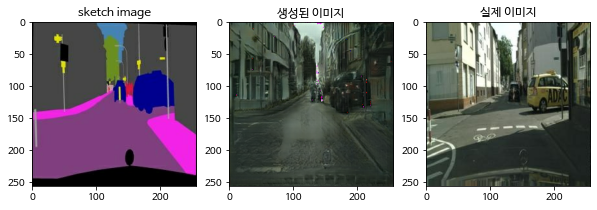

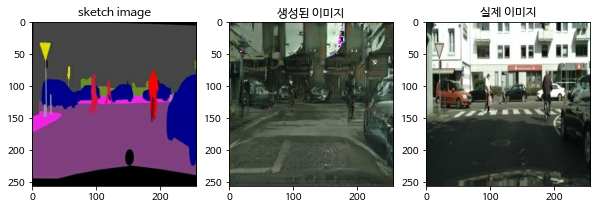

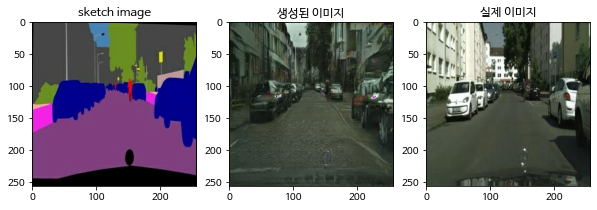

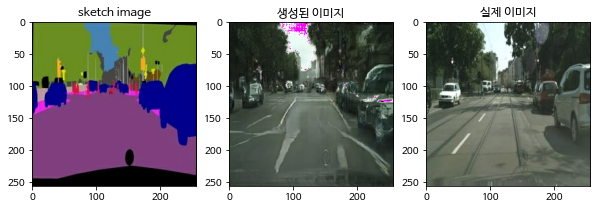

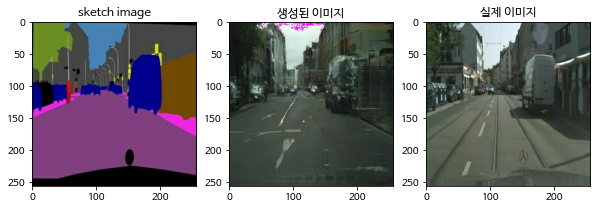

In [89]:
i=0
for file in f:
  sketch, colored = load_img(file)

  pred = generator(tf.expand_dims(sketch, 0))
  pred = denormalize(pred)

  plt.figure(figsize=(10,20))
  plt.subplot(5,3,1+i); plt.imshow(denormalize(sketch));plt.title("sketch image")
  plt.subplot(5,3,2+i); plt.imshow(pred[0]);plt.title("생성된 이미지")
  plt.subplot(5,3,3+i); plt.imshow(denormalize(colored)); plt.title("실제 이미지")
  i+=3
plt.show()

### 3-1. 데이터 augmentation 추가하기+epoch 200번 추가 : 학습

In [90]:
make_folder(2_1)# 폴더 만들어주는 함수

EPOCH[200] - STEP[250] /Generator_loss:0.8167 /L1_loss:0.1495 /Discriminator_loss:1.2590



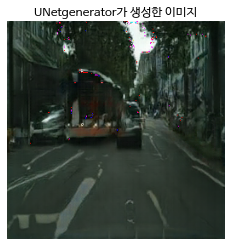

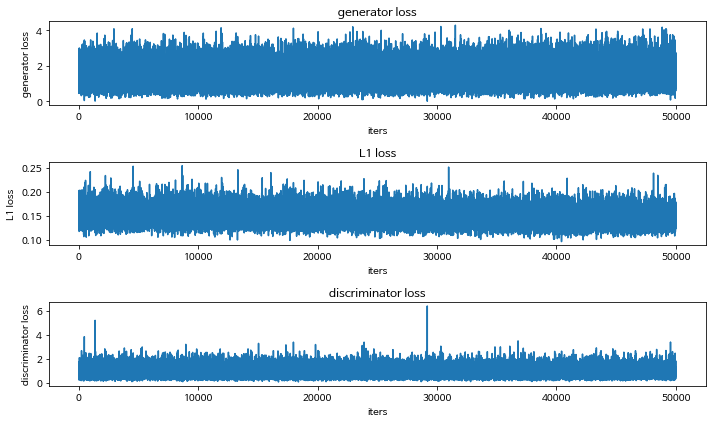

Time for training : 44 sec


In [91]:
try_=2_1
EPOCHS = 200
model1_loss={"gener_loss":[],"L1_loss":[],"discr_loss":[]}
save_every=1

for epoch in range(1, EPOCHS+1):  # epoch
    start=time.time()
    for i, (sketch, colored) in enumerate(train_images):  # batch step
        g_loss, l1_loss, d_loss = train_step(sketch, colored,L1_lambda=100) # L1 손실의 lambda 를 튜닝
        model1_loss["gener_loss"].append(g_loss)
        model1_loss["L1_loss"].append(l1_loss)
        model1_loss["discr_loss"].append(d_loss)
        
        
        # 50회 반복마다 손실을 출력합니다.
        if (i+1) % 50 == 0:
            display.clear_output(wait=True) # 셀의 화면 output을 지운다
            print(f"EPOCH[{epoch}] - STEP[{i+1}] /Generator_loss:{g_loss.numpy():.4f} /L1_loss:{l1_loss.numpy():.4f} /Discriminator_loss:{d_loss.numpy():.4f}", end="\n\n")
        
            test_ind = 1
            f = data_path + os.listdir(data_path)[test_ind]
            sketch, colored = load_img(f)
            pred = denormalize(generator(tf.expand_dims(sketch, 0)))
            # 생성된 이미지 시각화
            plt.imshow(pred[0])
            plt.title("UNetgenerator가 생성한 이미지")
            plt.axis("off")

            plt.savefig('/content/drive/MyDrive/AIFFEL/E17/cityscapes/try{}/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                       .format( try_,epoch,i))
            plt.show()
            # loss 시각화
            plt.figure(figsize=(10,6))
            plt.subplot(311)
            plt.title("generator loss")
            plt.plot(range(len(model1_loss["gener_loss"])), model1_loss["gener_loss"])
            plt.xlabel("iters")
            plt.ylabel("generator loss")

            plt.subplot(312)
            plt.title("L1 loss")
            plt.plot(range(len(model1_loss["L1_loss"])), model1_loss["L1_loss"])
            plt.xlabel("iters")
            plt.ylabel("L1 loss")

            plt.subplot(313)
            plt.title("discriminator loss")
            plt.plot(range(len(model1_loss["discr_loss"])), model1_loss["discr_loss"])
            plt.xlabel("iters")
            plt.ylabel("discriminator loss")            
            plt.savefig('/content/drive/MyDrive/AIFFEL/E17/cityscapes/try{}/training_history/train_history_{}_{:04d}.png'
                        .format(try_,epoch,i))
            plt.tight_layout()
            plt.show()
            
    if epoch % save_every == 0 :
        checkpoint_dir ='/content/drive/MyDrive/AIFFEL/E17/cityscapes/try{}/training_checkpoints'.format(try_)
        checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
        # checkpoint 저장
        checkpoint = tf.train.Checkpoint(generator_optimizer=gene_opt,
                                         discriminator_optimizer=disc_opt,
                                         generator=generator,
                                         discriminator=discriminator)
        
        checkpoint.save(file_prefix=checkpoint_prefix)
    
    print('Time for training : {} sec'.format(int(time.time()-start)))
    


### 3-2. 데이터 augmentation 추가하기+epoch 200번 추가 : 결과

In [92]:
test_path= "/content/drive/MyDrive/AIFFEL/E17/data/cityscapes/val/"
f = [test_path + i for i in os.listdir(test_path)]

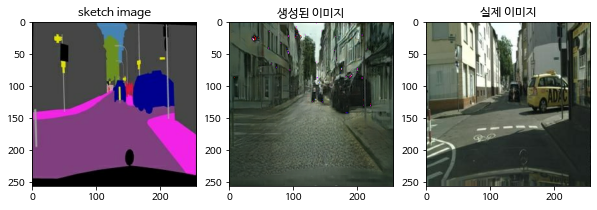

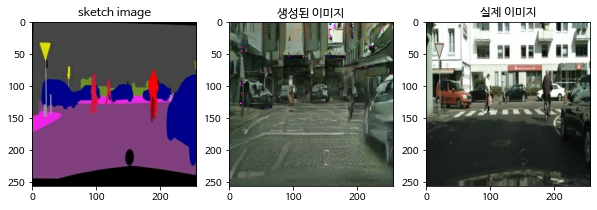

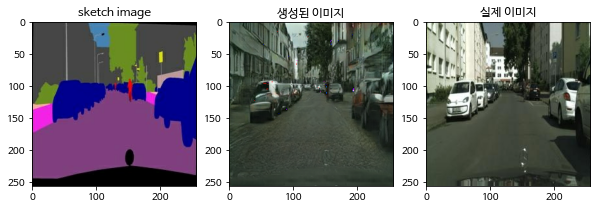

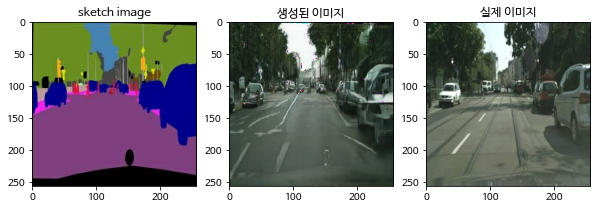

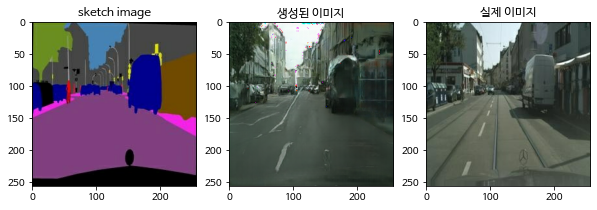

In [93]:
i=0
for file in f:
  sketch, colored = load_img(file)

  pred = generator(tf.expand_dims(sketch, 0))
  pred = denormalize(pred)

  plt.figure(figsize=(10,20))
  plt.subplot(5,3,1+i); plt.imshow(denormalize(sketch));plt.title("sketch image")
  plt.subplot(5,3,2+i); plt.imshow(pred[0]);plt.title("생성된 이미지")
  plt.subplot(5,3,3+i); plt.imshow(denormalize(colored)); plt.title("실제 이미지")
  i+=3
plt.show()

### 4-1. 데이터 augmentation 추가하기+ L1의 Lambda 10으로 : 학습

In [ ]:
make_folder(2_1)# 폴더 만들어주는 함수

EPOCH[200] - STEP[250] /Generator_loss:0.8167 /L1_loss:0.1495 /Discriminator_loss:1.2590



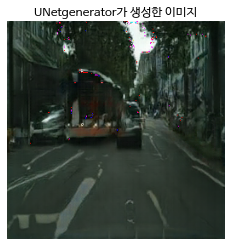

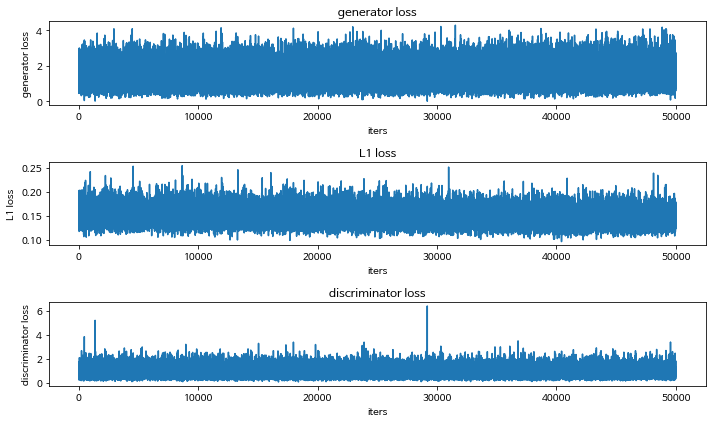

Time for training : 44 sec


In [ ]:
try_=2_1
EPOCHS = 200
model1_loss={"gener_loss":[],"L1_loss":[],"discr_loss":[]}
save_every=1

for epoch in range(1, EPOCHS+1):  # epoch
    start=time.time()
    for i, (sketch, colored) in enumerate(train_images):  # batch step
        g_loss, l1_loss, d_loss = train_step(sketch, colored,L1_lambda=100) # L1 손실의 lambda 를 튜닝
        model1_loss["gener_loss"].append(g_loss)
        model1_loss["L1_loss"].append(l1_loss)
        model1_loss["discr_loss"].append(d_loss)
        
        
        # 50회 반복마다 손실을 출력합니다.
        if (i+1) % 50 == 0:
            display.clear_output(wait=True) # 셀의 화면 output을 지운다
            print(f"EPOCH[{epoch}] - STEP[{i+1}] /Generator_loss:{g_loss.numpy():.4f} /L1_loss:{l1_loss.numpy():.4f} /Discriminator_loss:{d_loss.numpy():.4f}", end="\n\n")
        
            test_ind = 1
            f = data_path + os.listdir(data_path)[test_ind]
            sketch, colored = load_img(f)
            pred = denormalize(generator(tf.expand_dims(sketch, 0)))
            # 생성된 이미지 시각화
            plt.imshow(pred[0])
            plt.title("UNetgenerator가 생성한 이미지")
            plt.axis("off")

            plt.savefig('/content/drive/MyDrive/AIFFEL/E17/cityscapes/try{}/generated_samples/sample_epoch_{:04d}_iter_{:03d}.png'
                       .format( try_,epoch,i))
            plt.show()
            # loss 시각화
            plt.figure(figsize=(10,6))
            plt.subplot(311)
            plt.title("generator loss")
            plt.plot(range(len(model1_loss["gener_loss"])), model1_loss["gener_loss"])
            plt.xlabel("iters")
            plt.ylabel("generator loss")

            plt.subplot(312)
            plt.title("L1 loss")
            plt.plot(range(len(model1_loss["L1_loss"])), model1_loss["L1_loss"])
            plt.xlabel("iters")
            plt.ylabel("L1 loss")

            plt.subplot(313)
            plt.title("discriminator loss")
            plt.plot(range(len(model1_loss["discr_loss"])), model1_loss["discr_loss"])
            plt.xlabel("iters")
            plt.ylabel("discriminator loss")            
            plt.savefig('/content/drive/MyDrive/AIFFEL/E17/cityscapes/try{}/training_history/train_history_{}_{:04d}.png'
                        .format(try_,epoch,i))
            plt.tight_layout()
            plt.show()
            
    if epoch % save_every == 0 :
        checkpoint_dir ='/content/drive/MyDrive/AIFFEL/E17/cityscapes/try{}/training_checkpoints'.format(try_)
        checkpoint_prefix = os.path.join(checkpoint_dir, "ckpt")
        # checkpoint 저장
        checkpoint = tf.train.Checkpoint(generator_optimizer=gene_opt,
                                         discriminator_optimizer=disc_opt,
                                         generator=generator,
                                         discriminator=discriminator)
        
        checkpoint.save(file_prefix=checkpoint_prefix)
    
    print('Time for training : {} sec'.format(int(time.time()-start)))
    


### 3-2. 데이터 augmentation 추가하기+epoch 200번 추가 : 결과

In [ ]:
test_path= "/content/drive/MyDrive/AIFFEL/E17/data/cityscapes/val/"
f = [test_path + i for i in os.listdir(test_path)]

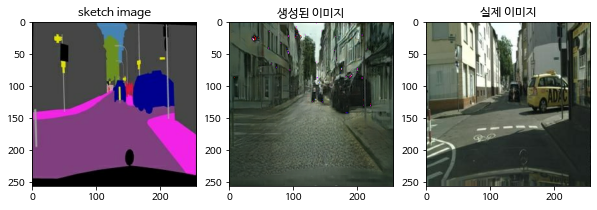

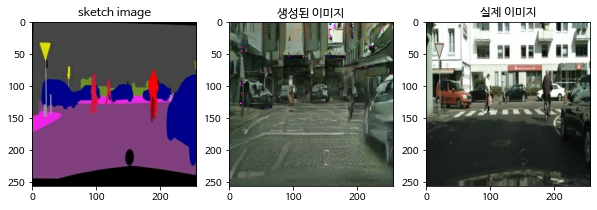

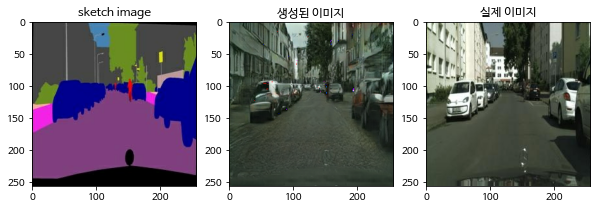

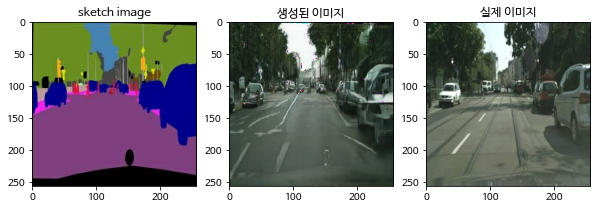

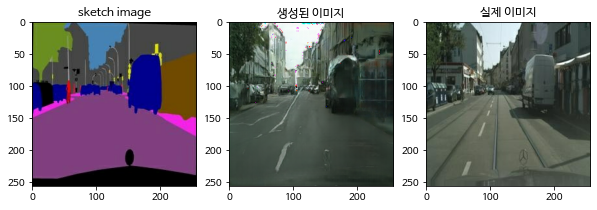

In [ ]:
i=0
for file in f:
  sketch, colored = load_img(file)

  pred = generator(tf.expand_dims(sketch, 0))
  pred = denormalize(pred)

  plt.figure(figsize=(10,20))
  plt.subplot(5,3,1+i); plt.imshow(denormalize(sketch));plt.title("sketch image")
  plt.subplot(5,3,2+i); plt.imshow(pred[0]);plt.title("생성된 이미지")
  plt.subplot(5,3,3+i); plt.imshow(denormalize(colored)); plt.title("실제 이미지")
  i+=3
plt.show()